<h1 style="color:blue">Praktikum 2. EstNLTK</h1>
<h3 style="color:blue">Teksti segmenteerimine, morfoloogiline analüüs, õigekirjakontroll. Sõnapilved</h3>

Tänases praktikumis teeme lähemalt tutvust eesti keele töötlemiseks mõeldud Pythoni teegiga [EstNLTK](https://github.com/estnltk/estnltk). 
Alustame kõige põhilisemast: teksti segmenteerimine sõnadeks ja lauseteks ning morfoloogilise analüüsi teostamine. 
Need sammud on vajalikud enamiku keeletöötlusülesannete lahendamisel: kui suudame tekstist kätte saada laused ja sõnad, ning filtreerida neid lemmade, sõnaliikide ja morfoloogilise info järgi, saame ka otsida sõna esinemisi sõnavormist (käändest/pöördest) sõltumata, luua sõnade/lemmade sagedusloendeid ning visualiseerida neid näiteks sõnapilvede abil. 
Morfoloogilise analüüsi alusel saab ka tuvastada õigekirjavigu, mida on võimalik spelleri abil parandada.

**NB!** Edasine osa juhendist eeldab, et EstNLTK versioon 1.4.1 on installitud keskkonda, milles käesolev _notebook_ käivitatud on. Kui selline keskkond on veel loomata või ei mäleta, kuidas aktiveerida jms, siis tasub vaadata 1. praktikumi PDF-juhendit. Kui tekib probleeme, küsige julgelt abi: EstNLTK töölesaamine on oluline, kuna seda läheb vaja lisaks tänasele ka kõigis järgmistes praktikumides.

### Text objekti loomine

EstNLTK olulisimaks klassiks on Text. Selle kasutamiseks peame vastava klassi importima:

In [2]:
from estnltk import Text

Et oma teksti töötlema hakata, peame sellest tegema Text klassi objekti:

In [3]:
my_sentences = "Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks."

In [4]:
# Teeme oma teksti Text objektiks
text = Text(my_sentences)

In [5]:
text

{'text': 'Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks.'}

Nagu näeme, on põhimõtteliselt tegemist *dictionary* ehk sõnaraamatuga.

### Teksti segmenteerimine

Keeleandmete analüüsimiseks on esmalt vaja tekst tükeldada -- jagada lauseteks ja sõnadeks. 
Esmapilgul võib see tunduda ehk lihtne ülesanne, mille lahendamiseks piisaks standardteegi [_split()_](https://docs.python.org/3.5/library/stdtypes.html#str.split) meetodist.
Aga kui uurida tühikute ja punktuatsiooni kasutust tekstides detailsemalt, võib märgata üksjagu juhte, kus lihtne _split()_ rakendamine ei tööta.
Näiteks lauses

    Rattaralli toimub 29. mail 2016 ning selle stardi- ja finišipaik on Tartu kesklinnas, Turu tänaval.
  
on küll kaks punkti, aga ainult viimane tähistab lauselõppu -- **lausestaja** peab kuidagi aru saama, et kuupäeva järel olev punkt pole lauselõpp.

Ka teksti sõnedeks jagaja ehk **sõnestaja** peab olema kavalam kui tavaline _split()_: lisaks sõnade eraldamisele tühikute järgi tuleb ka punktuatsioonisümbolid sõnadest lahku tõsta: see on vajalik nii kõige lihtsamal sõnaotsingul, sõnade loendamisel kui ka edasisel automaattöötlemisel. Lisaks tuleb tegeleda probleemidega, kus sõnad on kogemata kokku kirjutatud, näiteks tekstis
    
    Iga päev teeme valikuid.Valime kõike alates pesupulbrist ja lõpetades poliitikutega. 

tuleb tuvastada, et `valikuid.Valime` ei ole mitte tavaline sõna, vaid seal on tarvis kaks "kokku kleebitud" sõna lahku tõsta.

Sedalaadi teksti segmenteerimise probleemidega tegeleb EstNLTK meie eest. 
Seega võime teksti lihtsalt failist sisse lugeda, konverteerida Text objektiks ja küsida sealt lauseid ja sõnu.
Lausete küsimine käib nt nii:

In [6]:
text.sentence_texts

['Mees peeti kinni ja viidi Tartu vanglasse.',
 'Sinna pidi ta jääma kolmeks kuuks.']

Kuigi _Text_-i atribuut `sentence_texts` annab laused mugavalt sõnedena kätte, on oluline ka teada, kuidas see info on talletatud _Text_-is kui sõnastikus. 
Nimelt on tegemist kihiga (ingl *layer*), kus on täpsustatud kihi elementide (lausete) asukohad algses tekstis. 
Näiteks saame lausete asukohad kätte nii:

In [7]:
text.sentences

[{'end': 42, 'start': 0}, {'end': 77, 'start': 43}]

Algus- ja lõpp-positsioon (*start* ja *end*) näitavad, mitmenda märgi juures vastav lause algab või lõppeb.

Kui oleme atribuudi `sentence_texts` (või `sentences`) abil küsinud infot lausete kohta, siis lisatakse sõnastikku uus võti `'sentences'`, mille all ongi informatsioon lausete kohta kõige algsemal kujul:

In [8]:
text

{'paragraphs': [{'end': 77, 'start': 0}],
 'sentences': [{'end': 42, 'start': 0}, {'end': 77, 'start': 43}],
 'text': 'Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks.'}

Lisaks tekkis lausete küsimisel ka lõikude kiht (`'paragraphs'`), kuna teksti lõikudeks jagamine on lausestamise eelduseks.

Kui lõigud ja laused on olemas, siis saame teksti jagada ka sõnadeks. 
Jällegi, esmalt küsime sõnade järele:

In [9]:
text.words

[{'end': 4, 'start': 0, 'text': 'Mees'},
 {'end': 10, 'start': 5, 'text': 'peeti'},
 {'end': 16, 'start': 11, 'text': 'kinni'},
 {'end': 19, 'start': 17, 'text': 'ja'},
 {'end': 25, 'start': 20, 'text': 'viidi'},
 {'end': 31, 'start': 26, 'text': 'Tartu'},
 {'end': 41, 'start': 32, 'text': 'vanglasse'},
 {'end': 42, 'start': 41, 'text': '.'},
 {'end': 48, 'start': 43, 'text': 'Sinna'},
 {'end': 53, 'start': 49, 'text': 'pidi'},
 {'end': 56, 'start': 54, 'text': 'ta'},
 {'end': 62, 'start': 57, 'text': 'jääma'},
 {'end': 70, 'start': 63, 'text': 'kolmeks'},
 {'end': 76, 'start': 71, 'text': 'kuuks'},
 {'end': 77, 'start': 76, 'text': '.'}]

... misjärel on lisandunud *Text* objektile `'words'` kiht:

In [10]:
text

{'paragraphs': [{'end': 77, 'start': 0}],
 'sentences': [{'end': 42, 'start': 0}, {'end': 77, 'start': 43}],
 'text': 'Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks.',
 'words': [{'end': 4, 'start': 0, 'text': 'Mees'},
  {'end': 10, 'start': 5, 'text': 'peeti'},
  {'end': 16, 'start': 11, 'text': 'kinni'},
  {'end': 19, 'start': 17, 'text': 'ja'},
  {'end': 25, 'start': 20, 'text': 'viidi'},
  {'end': 31, 'start': 26, 'text': 'Tartu'},
  {'end': 41, 'start': 32, 'text': 'vanglasse'},
  {'end': 42, 'start': 41, 'text': '.'},
  {'end': 48, 'start': 43, 'text': 'Sinna'},
  {'end': 53, 'start': 49, 'text': 'pidi'},
  {'end': 56, 'start': 54, 'text': 'ta'},
  {'end': 62, 'start': 57, 'text': 'jääma'},
  {'end': 70, 'start': 63, 'text': 'kolmeks'},
  {'end': 76, 'start': 71, 'text': 'kuuks'},
  {'end': 77, 'start': 76, 'text': '.'}]}

[split_by()](https://estnltk.github.io/estnltk/1.4.1/tutorials/text.html#splitting-by-layers) meetod võimaldab itereerida üle teksti lausete, sõnade (jm elementide) kaupa:

In [11]:
for sentence in text.split_by("sentences"):
    print("UUS LAUSE")
    print(sentence.text)
    for word in sentence.split_by("words"):
        print(word['text'])

UUS LAUSE
Mees peeti kinni ja viidi Tartu vanglasse.
Mees
peeti
kinni
ja
viidi
Tartu
vanglasse
.
UUS LAUSE
Sinna pidi ta jääma kolmeks kuuks.
Sinna
pidi
ta
jääma
kolmeks
kuuks
.


In [12]:
text

{'paragraphs': [{'end': 77, 'start': 0}],
 'sentences': [{'end': 42, 'start': 0}, {'end': 77, 'start': 43}],
 'text': 'Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks.',
 'words': [{'end': 4, 'start': 0, 'text': 'Mees'},
  {'end': 10, 'start': 5, 'text': 'peeti'},
  {'end': 16, 'start': 11, 'text': 'kinni'},
  {'end': 19, 'start': 17, 'text': 'ja'},
  {'end': 25, 'start': 20, 'text': 'viidi'},
  {'end': 31, 'start': 26, 'text': 'Tartu'},
  {'end': 41, 'start': 32, 'text': 'vanglasse'},
  {'end': 42, 'start': 41, 'text': '.'},
  {'end': 48, 'start': 43, 'text': 'Sinna'},
  {'end': 53, 'start': 49, 'text': 'pidi'},
  {'end': 56, 'start': 54, 'text': 'ta'},
  {'end': 62, 'start': 57, 'text': 'jääma'},
  {'end': 70, 'start': 63, 'text': 'kolmeks'},
  {'end': 76, 'start': 71, 'text': 'kuuks'},
  {'end': 77, 'start': 76, 'text': '.'}]}

**NB!** Kui töötate mahukate tekstidega ja oluline on kiirus, siis tasub arvesse võtta, et kui *Text* objektile on märgenduskiht juba lisatud ja soovite seda uuesti vaadata/kasutada, siis on efektiivsem käsitleda *Text* objekti kui sõnastikku, mitte kasutada atribuuti. Ehk 

`text['words']` 

on kiirem kui 

`text.words`

### Ülesanne 1. Kellel on pikem? (1p)
Võrrelge Indrek Hargla ja Karen Orlau tekstide lausete ja sõnade pikkusi. Selleks kirjutage funktsioon, millele antakse ette kataloogi asukoht ning mis leiab ja tagastab kõigi kataloogis olevate failide peale kokku:
* keskmise failipikkuse lausetes
* keskmise lausepikkuse sõnades
* keskmise sõnapikkuse tähemärkides

Jooksutage funktsiooni Indrek Hargla juttudel (kataloogis *hargla_texts*) ning Karen Orlau juttudel (kataloogis *orlau_texts*).

**Vihjeid:**
* Tekstide kodeeringuks on utf-8;
* Lausete ja sõnade arvu leidmiseks tekstidest kasutage EstNLTK-d. Teksti töötlemisel lause kaupa aitab [split_by()](https://estnltk.github.io/estnltk/1.4.1/tutorials/text.html#splitting-by-layers) meetod, samuti lause töötlemisel sõna kaupa;
* Kataloogi kõigi failide läbimisel on abiks *[os.listdir](https://docs.python.org/3.5/library/os.html#os.listdir)* - vt näidet:

In [13]:
import os
path = 'dummy_folder/'
for file in os.listdir(path):
    filename = os.path.join(path, file) 
    with open(filename, "r", encoding = 'utf-8') as fin:
        print(filename)
        print(fin.read())    

dummy_folder/file1.txt
Eestil on terve rida rahvusmüüte, mis pole tõesed ja on moonutused, kui mitte otse valed.

dummy_folder/file2.txt
Ühel õhtul toidupoodi minnes leidsin eest lagedad võiletid.



### Morfoloogiline analüüs

Eesti keeles on sõnadel teatavasti palju erinevaid vorme, nt nimisõnu saab kasutada 14 käändes ning lisaks muuta arvus (ainsus/mitmus).
Teksti töötluse seisukohast on aga tihti kasulik käsitleda ühe sõna kõiki vorme koos.
Siin tulebki appi morfoloogiline analüüs.
Lihtsustatult öeldes tegeleb morfoloogiline analüüs sõna struktuuri kindlakstegemisega: millistest tükkidest sõna koosneb? 
Sellise analüüsi käigus selgub aga ka palju muud kasulikku: milline on sõna algvorm, millist liiki sõnaga on tegu ja millised on tükkidele vastavad grammatilised kategooriad.

#### Sõnade lemmad

Morfoloogilise analüüsi üks olulisemaid tulemusi on see, et erinevad vormid taandatakse ühele kindlale kujule: leitakse iga sõna algvorm ehk **lemma**.
Nimisõnade puhul on selleks enamasti ainsuse nimetava vorm (nt sõnade _oad, ubade, ubasid_ lemmaks on _uba_), tegusõnade puhul aga _ma_-lõpuline vorm (nt sõnade _nägin, näeme, näe_ algvorm on _nägema_).

EstNLTK-s saab lemmad kätte klassimuutuja 'lemmas' abil:

In [14]:
text.lemmas

['mees',
 'pidama',
 'kinni',
 'ja',
 'viima',
 'Tartu',
 'vangla',
 '.',
 'sinna',
 'pidama',
 'tema',
 'jääma',
 'kolm',
 'kuu',
 '.']

#### Sõnaliigid ja grammatilised kategooriad

Laias laastus jagunevad sõnad _käändsõnadeks_ (nimi-, omadus-, ase-, arvsõnad), _pöördsõnadeks_ (tegusõnad e verbid) ning _muutumatuteks sõnadeks_ (sidesõnad, määrsõnad, kaassõnad, lühendid, lausemärgid).
Sõnaliik (ingl _part of speech_ ehk _pos_) ütleb meile esmajoones seda, millist infot sõna kohta analüüsil leida võib: käändsõnade puhul leitakse analüüsi käigus sõna kääne ja arv ning pöördsõnade puhul leitakse (grammatiline) isik, kõneviis, aeg, arv, tegumood ja kõneliik. 
Muutumatud sõnad (nt sidesõnad _ja_, _ning_, _või_) esinevad aga alati ühel kujul ning morfoloogilisel tasandil me nende kohta mingit lisainfot ei leiagi.

EstNLTK-s saab teksti sõnaliigid kätte klassimuutuja 'postags' abil:

In [15]:
text.postags

['S', 'V', 'D', 'J', 'V', 'H', 'S', 'Z', 'D', 'V', 'P', 'V', 'N', 'S', 'Z']

Nagu väljundist näha, kasutatakse sõnaliikide tähistamiseks lühendeid (_S_ - substantiiv e nimisõna, _V_ - verb e pöördsõna jne). Lühendid on lahti kirjutatud [selles tabelis](https://estnltk.github.io/estnltk/1.4.1/tutorials/morphology_tables.html#table-pos-tag-descriptions).

Kui on tarvis sõnade morfoloogiat detailsemalt uurida, siis _text.forms_ abil saab kätte ka sõnade grammatilised kategooriad (nt käändsõnade käände ja arvu).
Grammatilised kategooriad on samuti toodud lühenditena, käändsõnade kategoorialühendid on lahti seletatud [siin](https://estnltk.github.io/estnltk/1.4.1/tutorials/morphology_tables.html#table-noun-form-descriptions-vabamorf) ning verbide omad [siin](https://estnltk.github.io/estnltk/1.4.1/tutorials/morphology_tables.html#table-verb-form-descriptions-vabamorf).
Käesolevas praktikumis meil aga sellist detailsust tarvis pole, esialgu piisab teadmisest, et see info on vajadusel olemas.

#### Morfoloogilise analüüsi tulemused sõnastikuna

Kui kasutame atribuute _text.lemmas_ või _text.postags_, siis teostatakse tekstil automaatne morfoloogiline analüüs ning selle tulemused kirjutatakse `'words'` kihi alla. 
Seega uuesti `text.words` välja kutsudes on nüüd tulemus märksa detailsem:

In [16]:
text.words

[{'analysis': [{'clitic': '',
    'ending': '0',
    'form': 'sg n',
    'lemma': 'mees',
    'partofspeech': 'S',
    'root': 'mees',
    'root_tokens': ['mees']}],
  'end': 4,
  'start': 0,
  'text': 'Mees'},
 {'analysis': [{'clitic': '',
    'ending': 'ti',
    'form': 'ti',
    'lemma': 'pidama',
    'partofspeech': 'V',
    'root': 'pida',
    'root_tokens': ['pida']}],
  'end': 10,
  'start': 5,
  'text': 'peeti'},
 {'analysis': [{'clitic': '',
    'ending': '0',
    'form': '',
    'lemma': 'kinni',
    'partofspeech': 'D',
    'root': 'kinni',
    'root_tokens': ['kinni']}],
  'end': 16,
  'start': 11,
  'text': 'kinni'},
 {'analysis': [{'clitic': '',
    'ending': '0',
    'form': '',
    'lemma': 'ja',
    'partofspeech': 'J',
    'root': 'ja',
    'root_tokens': ['ja']}],
  'end': 19,
  'start': 17,
  'text': 'ja'},
 {'analysis': [{'clitic': '',
    'ending': 'di',
    'form': 'ti',
    'lemma': 'viima',
    'partofspeech': 'V',
    'root': 'vii',
    'root_tokens': ['vii']}

Nagu näha, on `'words'` kihi alla tekkinud alamkiht `'analysis'`.
Seal on juba meile tuttav informatsioon lemmade (`'lemma'`) ja sõnaliikide (`'partofspeech'`) kohta, aga veel leiab sealt infot  sõnalõppude (`'ending'`), [kliitiku](https://et.wikipedia.org/wiki/Liidik) (`'clitic'`) ja sõnavormile vastavate grammatiliste kateoogriate (`'form'`) kohta.
Lisaks pakuvad `'root'` ja `'root_tokens'` alternatiivsel kujul informatsiooni sõna lemma kohta.

**_Mitmesused analüüsil._** Oluline asi, mida tuleb morfoloogilise analüüsi puhul tähele panna: tulemused `'analysis'` all on esitatud (sõnastike) järjendina, nt teise sõna (_peeti_) analüüs on kujul:

       [{'clitic': '',
         'ending': 'ti',
         'form': 'ti',
         'lemma': 'pidama',
         'partofspeech': 'V',
         'root': 'pida',
         'root_tokens': ['pida']}]

Järjendit kasutatakse seetõttu, et analüüs ei pruugi alati olla üheselt määratav: ühe sõna morfoloogiliseks tõlgendamiseks võib olla rohkem kui üks võimalus.
Kui analüsaator leiab rohkem kui ühe tõlgenduse, siis sisaldab järjend tõlgendustele vastavat arvu sõnastikke.

#### Morfoloogilise analüüsi vaikesätted

Vaikimisi tehakse morfoloogiline analüüs alati koos **ühestamise**, **oletamise** ja **pärisnimeanalüüside pakkumisega**. Mida see tähendab?

**Morfoloogiline ühestamine**: kui ühe sõnavormi analüüsimiseks on mitu võimalust - näiteks sõna "peeti" võib olla nii vorm nimisõnast "peet" kui ka tegusõnast "pidama" - , siis valitakse välja antud (lause-)kontekstis kõige tõenäolisem tõlgendus. Seejuures jääb siiski mõningatel juhtudel mitmesus alles, nt järgmises näites on sõnal "surnud" neli analüüsivarianti.

In [17]:
Text("Mees oli surnud.").analysis

[[{'clitic': '',
   'ending': '0',
   'form': 'sg n',
   'lemma': 'mees',
   'partofspeech': 'S',
   'root': 'mees',
   'root_tokens': ['mees']}],
 [{'clitic': '',
   'ending': 'i',
   'form': 's',
   'lemma': 'olema',
   'partofspeech': 'V',
   'root': 'ole',
   'root_tokens': ['ole']}],
 [{'clitic': '',
   'ending': '0',
   'form': '',
   'lemma': 'surnud',
   'partofspeech': 'A',
   'root': 'surnud',
   'root_tokens': ['surnud']},
  {'clitic': '',
   'ending': '0',
   'form': 'sg n',
   'lemma': 'surnud',
   'partofspeech': 'A',
   'root': 'surnud',
   'root_tokens': ['surnud']},
  {'clitic': '',
   'ending': 'd',
   'form': 'pl n',
   'lemma': 'surnud',
   'partofspeech': 'A',
   'root': 'surnud',
   'root_tokens': ['surnud']},
  {'clitic': '',
   'ending': 'nud',
   'form': 'nud',
   'lemma': 'surema',
   'partofspeech': 'V',
   'root': 'sure',
   'root_tokens': ['sure']}],
 [{'clitic': '',
   'ending': '',
   'form': '',
   'lemma': '.',
   'partofspeech': 'Z',
   'root': '.',
  

 * _Lingivstiline vahemärkus:_ näites esinev sõna "surnud" mitmesus on üsna tüüpiline ka teistele _nud_-lõpulistele sõnadele: ühest küljest võib _nud_-lõpulist sõna tõlgendada kui omadussõna (`'partofspeech': 'A'`) -- kui mingi tegevuse tulemusena tekkinud "omadust", aga teisest küljest on see avatud ka verbi tõlgendusele (`'partofspeech': 'V'`) -- seda võib tõlgendada kui mingi tegevuse või protsessi seisundit (loe detailsemalt [siit](https://et.wikipedia.org/wiki/Mineviku_kesks%C3%B5na)). Sedalaadi mitmesuste lahendamine nõuab kõrgema tasandi (süntaksi, semantika) keeleanalüüsi ja seetõttu jäetakse need morfoloogilisel analüüsil targu lahendamata.

**Oletamine**: kui analüsaator ei leia tekstis esinevat sõna sõnastikust ega suuda seda analüüsida ka liitega või liitsõnaks, siis sõna kuju põhjal pakutakse eeldatav(ad) analüüs(id). Järgnevas näites kasutatud sõna "poodelungile" tänapäeva eesti keele sõnastikes ei esine, ent on eesti keele kõnelejale siiski lihtne mõista. Oletaja suudab õigesti määrata vormi, ent lemma jääb mitmeseks:

In [18]:
Text('Tüdrukud läksid poodelungile.').analysis

[[{'clitic': '',
   'ending': 'd',
   'form': 'pl n',
   'lemma': 'tüdruk',
   'partofspeech': 'S',
   'root': 'tüdruk',
   'root_tokens': ['tüdruk']}],
 [{'clitic': '',
   'ending': 'sid',
   'form': 'sid',
   'lemma': 'minema',
   'partofspeech': 'V',
   'root': 'mine',
   'root_tokens': ['mine']}],
 [{'clitic': '',
   'ending': 'le',
   'form': 'sg all',
   'lemma': 'poodelung',
   'partofspeech': 'S',
   'root': 'poodelung',
   'root_tokens': ['poodelung']},
  {'clitic': '',
   'ending': 'le',
   'form': 'sg all',
   'lemma': 'poodelungi',
   'partofspeech': 'S',
   'root': 'poodelungi',
   'root_tokens': ['poodelungi']},
  {'clitic': '',
   'ending': 'le',
   'form': 'sg all',
   'lemma': 'poodelunk',
   'partofspeech': 'S',
   'root': 'poodelunk',
   'root_tokens': ['poodelunk']}],
 [{'clitic': '',
   'ending': '',
   'form': '',
   'lemma': '.',
   'partofspeech': 'Z',
   'root': '.',
   'root_tokens': ['.']}]]

**Pärisnimeanalüüside pakkumine:** kui nimisõna algab suure algustähega, võib see olla nii tavaline sõna kui ka pärisnimi (nt _Trump_ võib olla nii teatud liiki mast kaardimängus kui ka perekonnanimi). 
Vaikimisi lisabki analüsaator igal sellisel juhul analüüsidesse ka pärisnime tõlgenduse.

In [19]:
Text('Kapten Trumm tasus arve').postags

['S', 'H', 'V', 'S']

In [20]:
Text('Kapten Trumm tasus arve').lemmas

['kapten', 'Trumm', 'tasuma', 'arve']

Eelmises näites sai sõna _Trumm_ tegelikult nii nimisõna kui pärisnime tõlgenduse, automaatühestamise käigus valiti aga välja pärisnime analüüs (sõnaliik: `'H'`, lemma: `'Trumm'`).

#### Morfoloogilise analüüsi sätete muutmine

Nii ühestajat, oletajat kui pärisnimede pakkujat on võimalik *Text* objekti loomisel ka välja lülitada. 

Ühestaja väljalülitamisel (`disambiguate = False`) antakse välja kõik võimalikud morfoloogilise analüüsi tõlgendused sõnade kohta (erinevad tõlgendused püstkriipsuga eraldatud):

In [21]:
Text("Mees oli surnud.", disambiguate = False).lemmas

['Mee|Mees|Mesi|mees|mesi', 'olema', 'surema|surnu|surnud', '.']

In [22]:
Text("Mees oli surnud.", disambiguate = False).postags

['H|S', 'V', 'A|S|V', 'Z']

Pärisnimede pakkuja väljalülitamisel (`propername = False`) kaovad ära pärisnimetõlgendused:

In [23]:
Text("Kapten Trumm tasus arve", propername = False, disambiguate = False).lemmas

['kapten', 'trumm', 'tasu|tasuma', 'arv|arve']

In [24]:
Text("Kapten Trumm tasus arve", propername = False, disambiguate = False).postags

['S', 'S', 'S|V', 'S']

Ning oletaja väljalülitamisel (`guess = False`) jäävad analüsaatori jaoks tundmatutele sõnadele analüüsid määramata:

In [25]:
Text("Tüdrukud läksid poodelungile.", guess = False, disambiguate = False, propername = False).lemmas

['tüdruk', 'minema', None, None]

In [26]:
Text("Tüdrukud läksid poodelungile.", guess = False, disambiguate = False, propername = False).postags

['S', 'V', None, None]

**NB!** Kui oletamine on välja lülitatud, jäävad analüüsid määramata ka kirjavahemärkidele. Seetõttu ongi eelmises näites kaks `None` analüüsi: üks sõna 'poodelungile' kohta ja teine '.' kohta.

**NB!** Oletamise väljalülitamine toimib ainult siis, kui ka ühestamine ja pärisnimede analüüs on välja lülitatud, sest ühestaja suudab ühestada vaid teksti, kus igal sõnal on analüüs olemas. Kui oletamine on välja lülitatud, aga teised parameetrid mitte, siis ignoreeritakse ka oletamise väljalülitamist.

### Ülesanne 2.  Morfoloogilise analüüsi katsetamine (1p)

Leidke praktikumi materjalide hulgast fail *parasiitlusest.txt*. Lugege fail sisse, konverteerige *Text* objektiks ning teostage morfoloogiline analüüs. Täiendage oma koodi nii, et saaks vastata järgmistele küsimustele:

A. Kui suur on dokumendi sõnavara (ehk unikaalsete tekstisõnede arv) ilma lemmatiseerimata?

B. Kui suur on dokumendi sõnavara lemmatiseeritult?

C. Mitu % sõnadest jääb mitmeseks (on mitu analüüsi) koos morfoloogilise ühestamisega?

D. Mitu % sõnadest jääb mitmeseks ilma morfoloogilise ühestamiseta?

**Vihjed:**
* Teksti kodeeringuks on utf-8

###  Õigekirjakontroll

EstNLTK-s on olemas tööriist õigekirjakontrolli jaoks, mida saab kasutada järgmiselt:

In [27]:
text = Text("Ma tahax minna järve äärde ja püda hauge, katikaid ja karpe.")

In [28]:
text.fix_spelling()

{'text': 'Ma tahaks minna järve äärde ja püüda hauge, kaikaid ja karpe.'}

Nagu näha, siis algses lauses on kolmest veast 2 korrektselt ära parandatud, kolmas aga mitte. Kui vaatame, milliseid sõnu asenduseks soovitatakse, siis näeme, et "katikaid" puhul on neli võimalust, korrektor valib aga esimese.

In [ ]:
text.get.word_texts.spelling.spelling_suggestions.as_dataframe

,word_texts,spelling,spelling_suggestions
0,Ma,True,[]
1,tahax,False,"[tahaks, taha, tahad]"
2,minna,True,[]
3,järve,True,[]
4,äärde,True,[]
5,ja,True,[]
6,püda,False,[püüda]
7,hauge,True,[]
8,",",True,[]
9,katikaid,False,"[kaikaid, latikaid, karikaid, katikaiad]"


### Ülesanne 3. Parandame vead (2p)

Kasutades EstNLTK õigekirjakontrolli võimalust, kirjutage kood, mis aitab parandada kirjavigu ning laseb kasutajal tehtavate asenduste osas kaasa rääkida. Selleks peaks kood sisendiks saama teksti ning kuvama kasutajale järjest lauseid, milles esineb õigekirjakontrollija meelest ebakorrektseid sõnu. Koos lausega võiks kuvada ka, millises sõnas probleem täpselt esineb.
* Kui EstNLTK-l soovitusi ei ole, paluge kasutajal õige variant sisestada. Tühja sisestuse korral jäetakse sõna algsele kujule, kui kasutaja pakub oma variandi, asendatakse sõna lauses sellega;
* Kui vigase sõna asemel on üks soovitus, siis asendatakse sõna sellega, lause ja asendus kuvatakse kasutajale sellegipoolest;
* Kui soovitusi on mitu, kuvatakse kasutajale lause ning variandid koos järjekorranumbriga ning küsitakse kasutaja sisendit, mitmes variant valida asenduseks. Arvestage, et erinevalt Pythonist eelistavad inimesed nummerdamist üldjuhul alates 1-st; 
* Programmi töö lõppedes väljastage kasutajale tema parandatud tekst tervikuna;

Vihjeid:
* [input()](https://docs.python.org/3/library/functions.html#input) kasutaja sisendi küsimiseks 
* [spellcheck_results](https://estnltk.github.io/estnltk/1.4.1/tutorials/text.html#correcting-spelling) klassimuutuja annab nii korrektsushinnangu kui sõnasoovitused

In [ ]:
name = input("Mis su nimi on? ")
print("Tere, " + name + "!")

### Sõnapilved

Sõnapilv on populaarne tekstiliste andmete esitamise viis. Kõige lihtsam on muidugi tükeldada tekst sõnadeks ning visualiseerida kõige sagedasemad sõnad. Paraku ei pruugi see olla väga informatiivne.

Siin on näiteks toodud ühe teatrietenduse arvustuse pealt genereeritud sõnapilv. Nagu näha, on enim esindatud asesõnad sidesõnad ja määrsõnad, mis eriti informatiivsed ei ole.

![title](wordcloud7.png)

### Ülesanne 4. Sõnapilv (1,5p)

Kaustas *teatriarvustused2* on toodud üheksa arvustust ühe teatrietenduse kohta. Koostage kaustas olevate tekstide põhjal informatiivsem sõnapilv. Kuna arvustuste puhul on huvitavad peamiselt kirjutajate poolt antud hinnangud, siis parema sõnapilve koostamiseks:
* lemmatiseerige tekstid
* kasutage sõnapilves ainult omadussõnu
* valige mõistlik hulk sõnu, mida visualiseerida - eeldatavasti sagedasemad, samas võib kasutada stoppsõnade loendit, et jätta välja sõnu, mis ei ole informatiivsed
* Ühestamata jäänud (püstkriipsuga eraldatud) lemmad sõnapilves ('jääma|jäänud' jms) esineda ei tohiks

**Vihjeid:**

* Tekstide kodeeringuks on utf-8

* Sõnapilve genereerimisel on abiks https://github.com/amueller/word_cloud teek. Kasutamiseks tuleb see installida praktikumiülesannete lahendamiseks kasutatavasse conda keskkonda käsuga

    `conda install -c conda-forge wordcloud`
    

* Sõnapilve visualiseerimiseks vajame ka matplotlib'i, mille saab installida käsuga

    `conda install matplotlib`
    

Ülaltoodud sõnapilv on genereeritud järgneva koodi abil:

In [1]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
with open("teatriarvustused2/arvustus8.txt", "r", encoding = 'utf-8') as fin:
    text = fin.read()

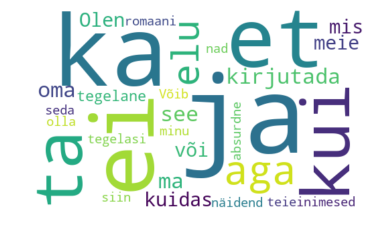

In [3]:
wordcloud = WordCloud(max_font_size = 160, max_words = 30, width = 500, height = 300, background_color = 'white').generate(text)
fig = plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Boonusülesanne.  (1p)

Vaadake Postimehe koostatud sõnapilve presidendi vabariigi aastapäeva kõne teksti pealt (pärit [siit](http://arvamus.postimees.ee/4027843/sonapilv-keda-voi-mida-mainis-kaljulaid-oma-kones-koige-enam)). Mõelge, mil moel saaks automaatse tekstitöötluse abil tulemust parandada. Genereerige uus ja parem sõnapilv (kõne teksti leiate failist *presidendi_tekst.txt*), mis oleks samuti Eesti kujuga. Näidis [siin.](https://github.com/amueller/word_cloud/blob/master/examples/masked.py)

![title](presidendipilv.png)